In [1]:
# This notebook runs from the projects root directory.
import os
PROJECT_ROOT_DIRECTORY = 'senior_project'
while os.path.basename(os.getcwd()) != PROJECT_ROOT_DIRECTORY:
    os.chdir(os.pardir)
print('Current working directory:', os.getcwd())

Current working directory: c:\Users\pavan\Desktop\senior_project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from stable_baselines3 import DQN, A2C, PPO, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv
from environments.discrete_env_v3 import PortfolioManagementEnv

In [3]:
experiment_id = f'EXPERIMENT_2_1_{int(time.time())}'
print(experiment_id)

EXPERIMENT_2_1_1678953968


In [4]:
train_df = pd.read_csv(f'data\\asset_classes_stationary_features_train.csv', index_col=0, parse_dates=True)
val_df = pd.read_csv('data\\asset_classes_stationary_features_val.csv', index_col=0, parse_dates=True)

ASSET_CLASSES = ['LARGE_CAP', 'SMALL_CAP', 'BONDS', 'CASH', 'REAL_ESTATE', 'COMMODITIES', 'GOLD']
FEATURES = ['RETURN_12', 'RETURN_26', 'RETURN_60', 'STD_20', 'STD_10']

RETURN_COLS = [asset_class for asset_class in ASSET_CLASSES]
FEATURE_COLS = [f'{asset_class}_{feature}' for asset_class in ASSET_CLASSES for feature in FEATURES]

In [5]:
WINDOW_SIZE = 40
EPISODE_LENGTH = 225
ALLOCATIONS_IN_OBS = True
DRAWDOWN_PENALTY_FACTOR = 10

In [6]:
train_envs = DummyVecEnv([
    lambda: PortfolioManagementEnv(
        train_df, 
        RETURN_COLS, 
        FEATURE_COLS, 
        window_size=WINDOW_SIZE, 
        episode_length=EPISODE_LENGTH, 
        allocations_in_obs=ALLOCATIONS_IN_OBS,
        drawdown_penalty_factor=DRAWDOWN_PENALTY_FACTOR,
    ) 
    for _ in range(12)
])

train_env = PortfolioManagementEnv(
    train_df, 
    RETURN_COLS, 
    FEATURE_COLS, 
    window_size=WINDOW_SIZE,
    episode_length=-1,
    allocations_in_obs=True,
    drawdown_penalty_factor=DRAWDOWN_PENALTY_FACTOR,
)

val_env = PortfolioManagementEnv(
    val_df, 
    RETURN_COLS, 
    FEATURE_COLS, 
    window_size=WINDOW_SIZE,
    episode_length=-1,
    allocations_in_obs=True,
    drawdown_penalty_factor=DRAWDOWN_PENALTY_FACTOR,
)

In [7]:
model = DQN(
    'MlpPolicy',
    train_envs,
    verbose=1,
    # tensorboard_log=log_dir,
    seed=5,
    learning_rate=0.0003,
    batch_size=64,
    exploration_fraction=1.03,
    buffer_size=100_000
)

Using cuda device


In [8]:
def evaluate_model(model, env, plot_ax=None, legend=False):

    obs, done = env.reset(), False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)

    values = env.get_portfolio_values()

    annualized_mean_return = values.pct_change(1).mean() * 252
    max_drawdown = abs((values / values.expanding(min_periods=1).max() - 1).min())
    calmar_ratio = annualized_mean_return / max_drawdown

    if plot_ax is not None:
        values.plot(ax=plot_ax, label=f'{model.num_timesteps} : {calmar_ratio:.2f}', legend=legend)

    return calmar_ratio

In [9]:
models_dir = f'experiments_2/models/{experiment_id}'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

  0%|          | 0/100 [00:00<?, ?it/s]

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 27892    |
|    time_elapsed     | 0        |
|    total_timesteps  | 2700     |
----------------------------------
------------------------------
| time/              |       |
|    episodes        | 8     |
|    fps             | 27608 |
|    time_elapsed    | 0     |
|    total_timesteps | 2700  |
------------------------------
------------------------------
| time/              |       |
|    episodes        | 12    |
|    fps             | 27329 |
|    time_elapsed    | 0     |
|    total_timesteps | 2700  |
------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.502    |
| time/               |          |
|    episodes         | 16       |
|    fps              | 27966    |
|    time_elapsed     | 0        |
|    t

C:\Users\pavan\AppData\Local\Temp\ipykernel_30756\2895074170.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout();


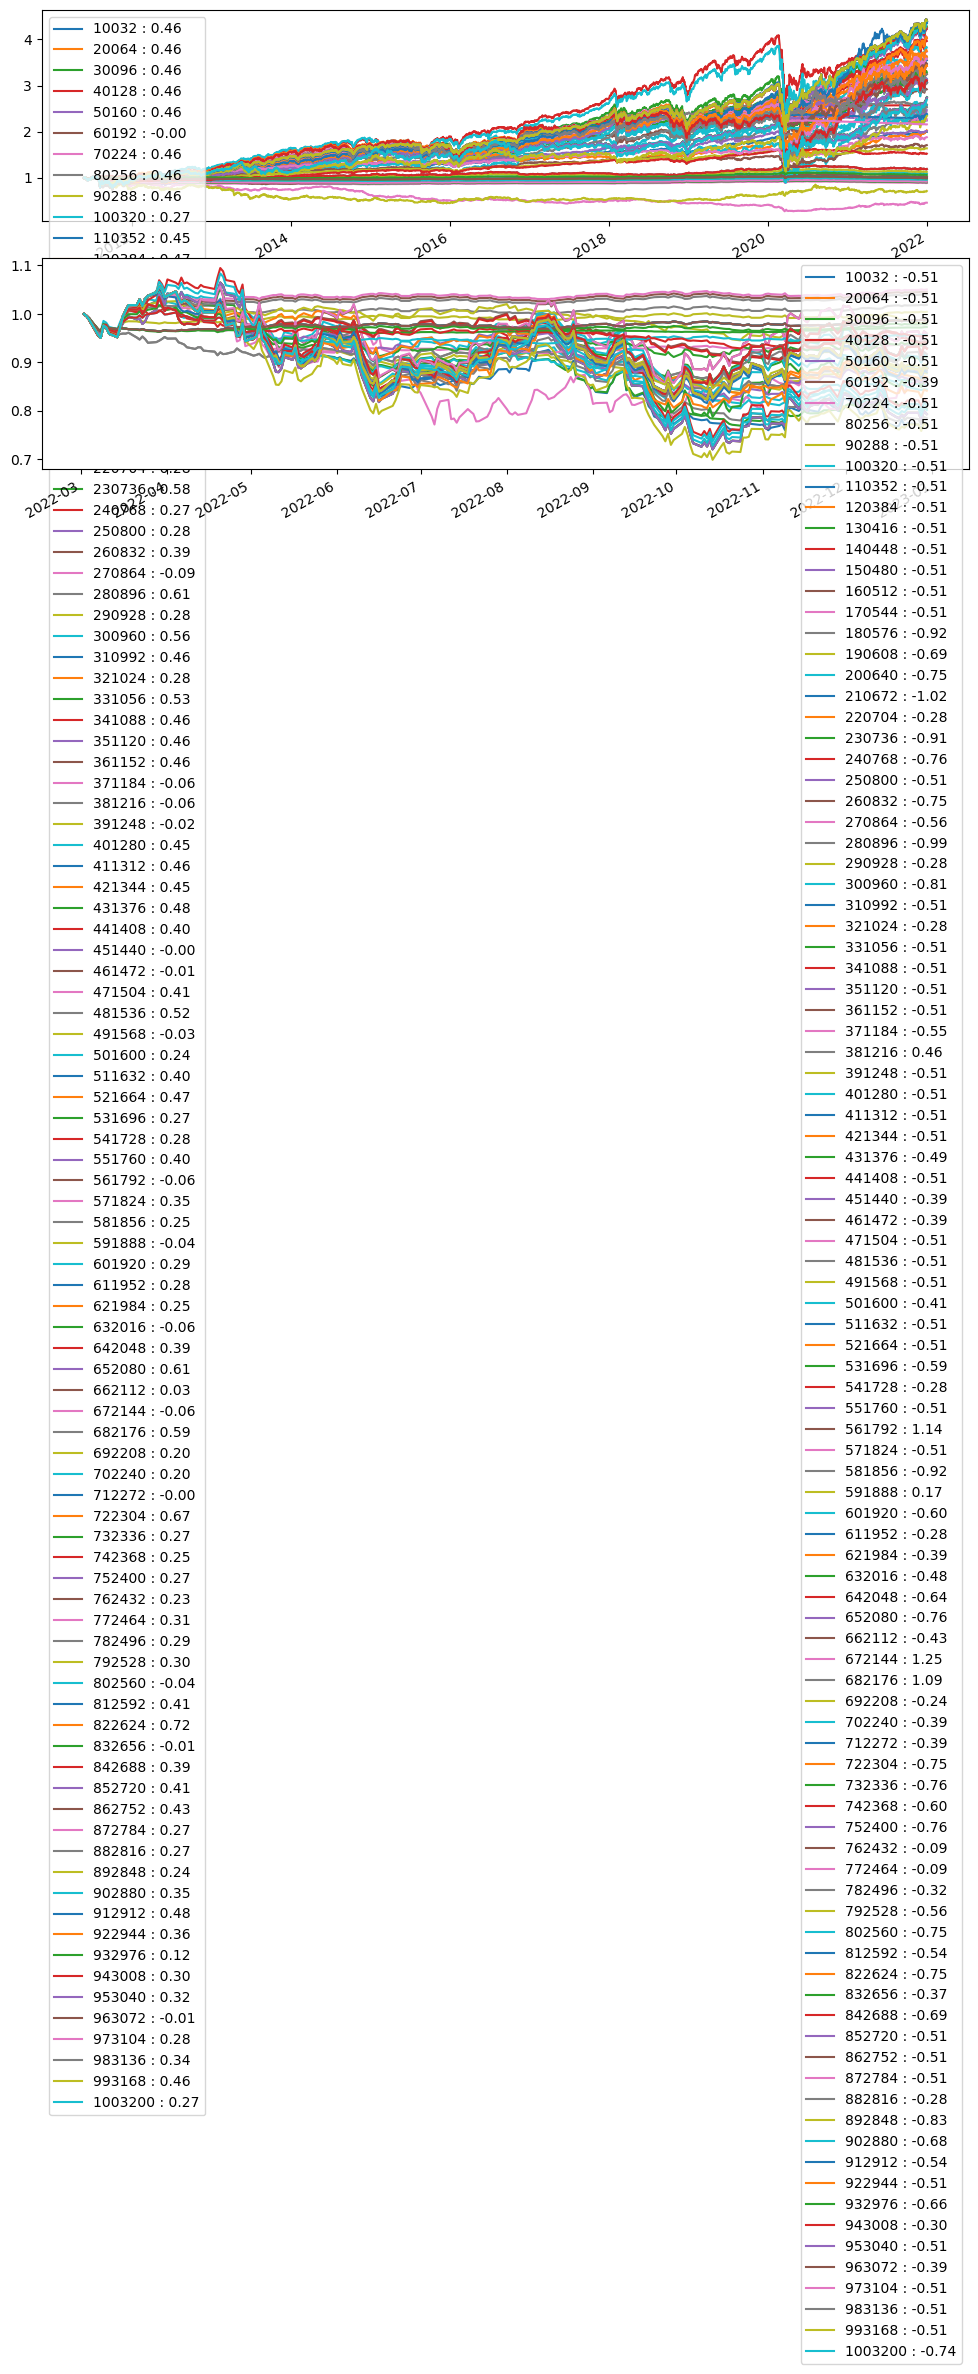

In [10]:
fig, axes = plt.subplots(2, figsize=(10,6))
plt.tight_layout();

TIMESTEPS = 10_000 # number of timesteps between saves and evaluations
for i in tqdm(range(100)):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False)
    # model.save(f'{models_dir}/{model.num_timesteps}')
    evaluate_model(model, train_env, plot_ax=axes[0], legend=True)
    evaluate_model(model, val_env, plot_ax=axes[1], legend=True)

plt.tight_layout();